In [1]:
#imports
%matplotlib notebook
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.cm as cm
import matplotlib.colors as colors

from functions.utils import n_params, vector_to_state_dict, state_dict_to_vector, get_param_state
from functions.my_optimizers import GDMethod,MomentumMethod, Adagrad, RMSProp,LinearLrUpdate, StepLrUpdate, ExpLrUpdate, CostLrUpdate
from functions.mod_adam import Adam


In [2]:
num_epochs = 30
batch_size = 32

lr = 0.0001
betas = (0.9, 0.999)

In [3]:
!nvidia-smi

Sun Sep 19 16:45:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   36C    P2    36W / 250W |   1287MiB / 12066MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   

In [4]:
device = 'cuda:2'

In [5]:
#creating datasets

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose

# Download training data from open datasets.
full_training_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
full_test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

#select smaller subset of datasets
# training_dataset = torch.utils.data.Subset(full_training_data, [i for i in range(5000)])
# test_dataset = torch.utils.data.Subset(full_test_data, [i for i in range(500)])

# Create data loaders.
train_data = DataLoader(full_training_dataset, batch_size=batch_size, shuffle=True)
test_data = DataLoader(full_test_dataset, batch_size=batch_size)

In [6]:
#defining model, device and loss fn, called Model, device, and loss_fn
#need to add attribute "self.param_updates" that is initialized to 0
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.flatten = nn.Flatten()
        self.param_updates = 0
        self.lin1 = nn.Linear(28*28, 20)
        self.lin2 = nn.Linear(20, 10)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        out1 = self.flatten(x)
        out2 = self.lin1(out1)
        out2_1 = self.relu(out2)
        out3 = self.lin2(out2_1)
        logits = self.sigmoid(out3)
        return logits

loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.NLLLoss()
model = Model()
model.to(device)

Model(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin1): Linear(in_features=784, out_features=20, bias=True)
  (lin2): Linear(in_features=20, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

In [7]:
#getting number of parameters in model
num_params = n_params(model, verbose=True)
print(num_params)
#defing arrays to store model paramter states as it trains
num_param_states = num_epochs*len([0 for val in train_data])+1
# +1 so that I can include initial parameter state
param_states = np.zeros((num_param_states, num_params))
print('param states shape:', param_states.shape)

cmap = cm.magma
norm = colors.Normalize(vmin=0, vmax=num_param_states)

#the step corresponding to the end of an epoch
epoch_indices = np.zeros((num_epochs+1))

train_loss = np.zeros((num_param_states))
ep_train_loss = np.zeros((num_epochs+1))
test_loss = np.zeros((num_epochs+1))
test_acc = np.zeros((num_epochs+1))

#storing adam inst. stuff
grads = np.zeros_like(param_states)
m1s = np.zeros_like(param_states)
m2s = np.zeros_like(param_states)

lin1.weight size: 15680
lin1.bias size: 20
lin2.weight size: 200
lin2.bias size: 10
Total num. parameters: 15910
15910
param states shape: (56251, 15910)


In [8]:
def train(dataloader, model, loss_fn, optimizer, param_states,
          train_loss=train_loss, ep_train_loss = ep_train_loss, grads=grads, m1s=m1s, m2s=m2s):
    size = len(dataloader)
    
    total_loss = 0.0
    
    if model.param_updates == 0:
        param_states[model.param_updates] = get_param_state(model)
        model.param_updates += 1

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        grad, m1, m2, _ = optimizer.step()
    
        #-1 because measured at prev step
        grads[model.param_updates-1] = np.concatenate([g.flatten() for g in grad])
        m1s[model.param_updates-1] = np.concatenate([m.flatten() for m in m1])
        m2s[model.param_updates-1] = np.concatenate([m.flatten() for m in m2])
        
        param_states[model.param_updates] = get_param_state(model)

        train_loss[model.param_updates] = loss.item()
        total_loss += loss.item()

        model.param_updates += 1
        
    return total_loss/size

#function which applies model to test dataset
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_minibatches = len(dataloader)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_minibatches
    correct /= size
    return test_loss, correct

In [9]:
model.param_updates=0

#Choose optimizer

#optimizer = GDMethod(model.parameters(), lr=lr)
#optimizer = MomentumMethod(model.parameters(), lr=lr)
#optimizer = Adagrad(model.parameters(), lr=lr)
#optimizer = RMSProp(model.parameters(), lr=lr, ema_coeff=0.9)
optimizer = Adam(model.parameters(), lr=lr, betas=betas)

#Getting initial train and test loss
train_loss[0],_ = test(train_data, model, loss_fn)
ep_train_loss[0],_ = test(train_data, model, loss_fn)
test_loss[0],test_acc[0] = test(test_data, model, loss_fn)

for j in range(num_epochs):
    print(' - Epoch: %i'%(j+1))

    #Choose lr scheduler
    
    #this_lr = LinearLrUpdate(j, lr, optimizer, decay_rate=2)
    #this_lr = StepLrUpdate(j, lr, optimizer, decay_rate=0.9, drop_rate=1)
    #this_lr = ExpLrUpdate(j, lr, optimizer, decay_rate=1)

    ep_train_loss[j+1] = train(train_data, model, loss_fn, optimizer, param_states, train_loss)
    test_loss[j+1],test_acc[j+1] = test(test_data, model, loss_fn)
    epoch_indices[j+1] = model.param_updates-1

steps = param_states[1:] - param_states[:-1]

 - Epoch: 1
 - Epoch: 2
 - Epoch: 3
 - Epoch: 4
 - Epoch: 5
 - Epoch: 6
 - Epoch: 7
 - Epoch: 8
 - Epoch: 9
 - Epoch: 10
 - Epoch: 11
 - Epoch: 12
 - Epoch: 13
 - Epoch: 14
 - Epoch: 15
 - Epoch: 16
 - Epoch: 17
 - Epoch: 18
 - Epoch: 19
 - Epoch: 20
 - Epoch: 21
 - Epoch: 22
 - Epoch: 23
 - Epoch: 24
 - Epoch: 25
 - Epoch: 26
 - Epoch: 27
 - Epoch: 28
 - Epoch: 29
 - Epoch: 30


<IPython.core.display.Javascript object>


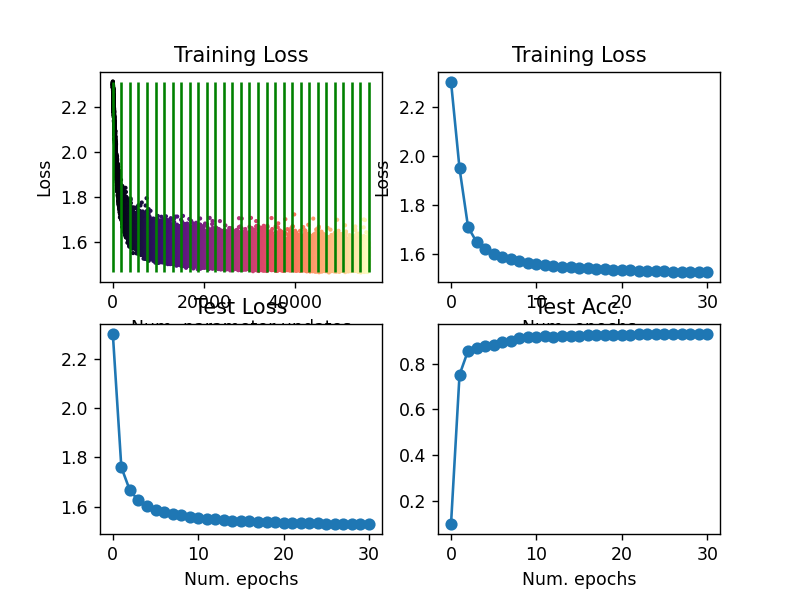

In [10]:
time = np.array([i for i in range(num_param_states)])

#plotting loss over training
plt.figure()
plt.subplot(2, 2, 1)
plt.title('Training Loss')
plt.xlabel('Num. parameter updates')
plt.ylabel('Loss')
plt.scatter(time, train_loss, c=cm.magma(time/(num_param_states-1)), s=2)
plt.vlines(epoch_indices, min(train_loss), max(train_loss), linestyle='solid', colors='g')

plt.subplot(2, 2, 2)
plt.title('Training Loss')
plt.xlabel('Num. epochs')
plt.ylabel('Loss')
#plt.plot(train_loss[[int(_) for _ in epoch_indices]], 'o-')
plt.plot(ep_train_loss, 'o-')

#plotting loss over testing
plt.subplot(2, 2, 3)
plt.title('Test Loss')
plt.xlabel('Num. epochs')
plt.plot(test_loss, 'o-')

plt.subplot(2, 2, 4)
plt.title('Test Acc.')
plt.xlabel('Num. epochs')
plt.plot(test_acc, 'o-')

In [11]:
"""
List of all available params from training:
    - param_states is np array (num_param_states, num_params) of model states
    - train_loss, test_loss, test_acc are self explanatory, except train_loss is per minibatch
    - epoch_indices is a np arr (num_epochs+1), epoch_indices[i] = param_state idx at end of ith epoch
    - grads, m1s, m2s are np arrays (num_param_states, num_params) of grad, m1, m2 from adam
    - steps is np array (num_param_states-1, num_params) of model steps
""" 

'\nList of all available params from training:\n    - param_states is np array (num_param_states, num_params) of model states\n    - train_loss, test_loss, test_acc are self explanatory, except train_loss is per minibatch\n    - epoch_indices is a np arr (num_epochs+1), epoch_indices[i] = param_state idx at end of ith epoch\n    - grads, m1s, m2s are np arrays (num_param_states, num_params) of grad, m1, m2 from adam\n    - steps is np array (num_param_states-1, num_params) of model steps\n'

In [12]:
from sklearn.decomposition import PCA
print('PCA fitting:')

pca = PCA(n_components=2)
pca.fit(param_states)
pca_embed = pca.transform(param_states)
print('components_ shape:', pca.components_.shape, '\nsamples shape:', param_states.shape, '\ntransformed shape:', pca_embed.shape)

print("PCA explains", pca.explained_variance_ratio_, '->', sum(pca.explained_variance_ratio_)*100, '% of variance')

PCA fitting:
components_ shape: (2, 15910) 
samples shape: (56251, 15910) 
transformed shape: (56251, 2)
PCA explains [0.92223599 0.06342575] -> 98.56617388330135 % of variance


Distance travelled in parameter space: 24.89569438667209


<IPython.core.display.Javascript object>


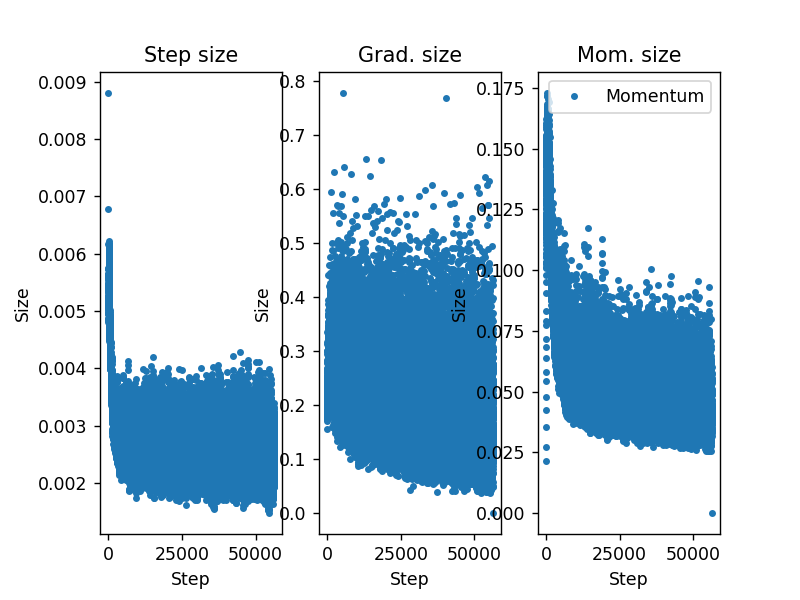

<IPython.core.display.Javascript object>


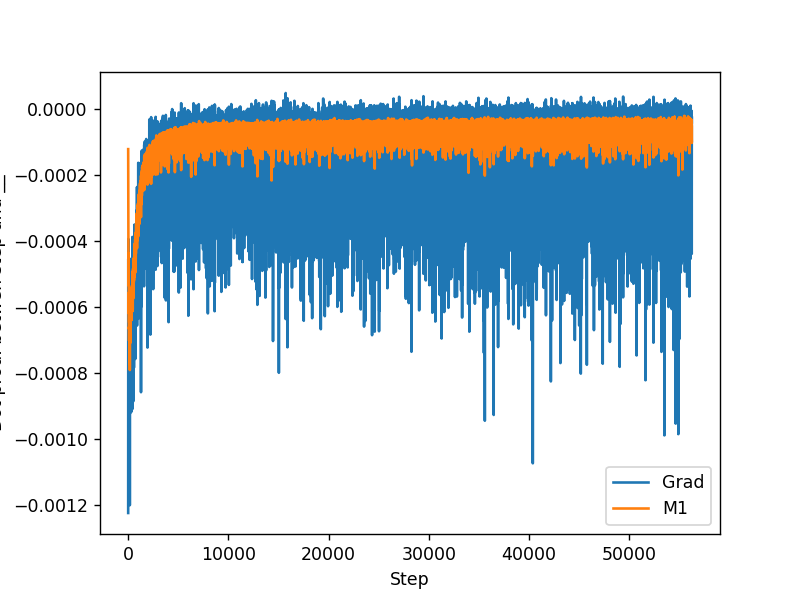

In [13]:
#Looking at properties of the steps the model took

#how far model has learned in param space
learning_length = np.linalg.norm(param_states[-1]-param_states[0])
print('Distance travelled in parameter space:', learning_length)

plt.figure()
plt.subplot(1, 3, 1)
plt.title("Step size")
plt.plot([i+1 for i in range(len(steps))], np.linalg.norm(steps, axis=-1), '.', label='Step')
plt.ylabel('Size')
plt.xlabel("Step")

plt.subplot(1, 3, 2)
plt.title("Grad. size")
plt.plot([i for i in range(len(grads))], np.linalg.norm(grads, axis=-1), '.', label='Grad')
plt.ylabel('Size')
plt.xlabel("Step")

plt.subplot(1, 3, 3)
plt.title("Mom. size")
plt.plot([i for i in range(len(m1s))], np.linalg.norm(m1s, axis=-1), '.', label='Momentum')
plt.ylabel('Size')
plt.xlabel("Step")
plt.legend()

plt.figure()
plt.ylabel('Dot prod. betwen step and __')
plt.xlabel("Step")
plt.plot([np.dot(steps[i], grads[i]) for i in range(num_param_states-1)], label='Grad')
plt.plot([np.dot(steps[i], m1s[i]) for i in range(num_param_states-1)], label='M1')
plt.legend()

<IPython.core.display.Javascript object>


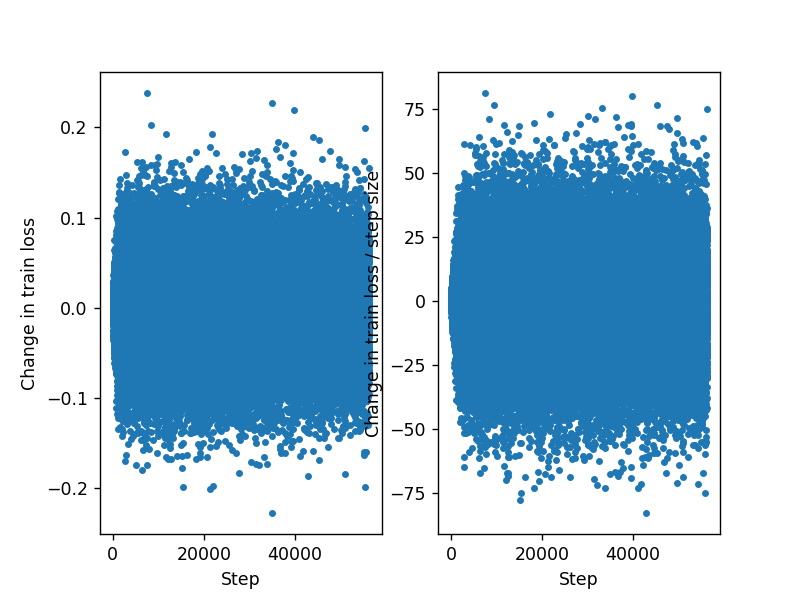

Text(0, 0.5, 'Change in train loss / step size')

In [14]:
#change in train loss per change in param (effective gradient)
change_train_loss = train_loss[1:] - train_loss[:-1]
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(change_train_loss, '.')
plt.xlabel("Step")
plt.ylabel("Change in train loss")

plt.subplot(1, 2, 2)
plt.plot(change_train_loss/np.linalg.norm(steps, axis=-1), '.')
plt.xlabel("Step")
plt.ylabel("Change in train loss / step size")

<IPython.core.display.Javascript object>


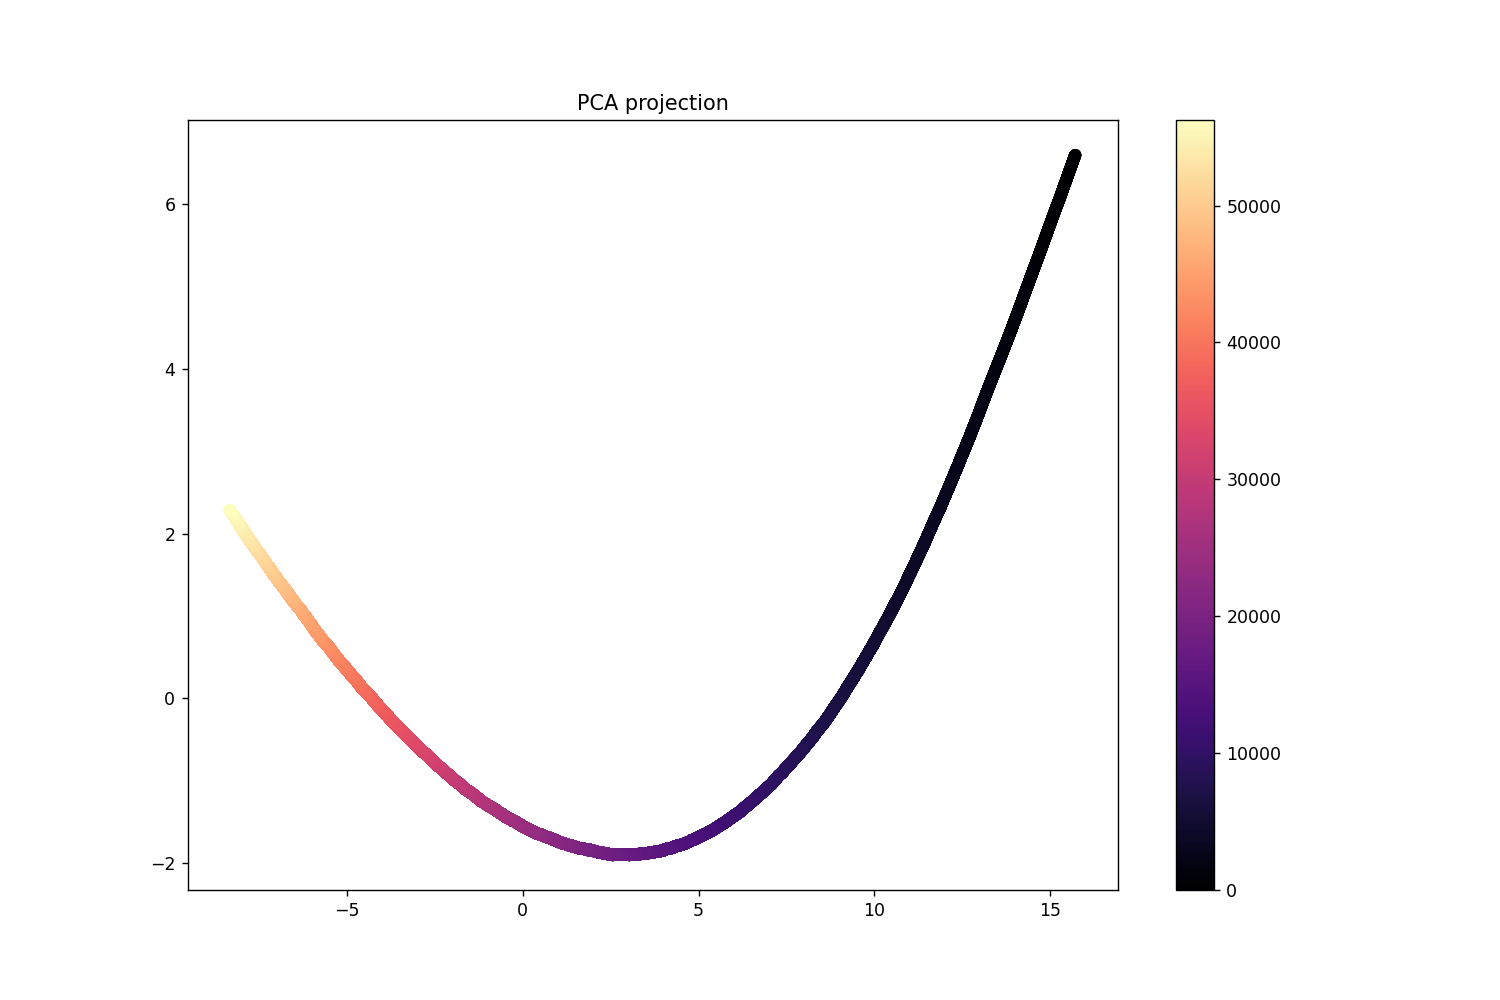

In [15]:
plt.figure(figsize=(12, 8))
plt.title('PCA projection')
plt.scatter(pca_embed[:, 0], pca_embed[:,1], c=[val for val in cmap(time/(num_param_states-1))])
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap))

In [16]:
#the two vectors from PCA, with shape (num_params)
pca_vec1 = pca.components_[0]
pca_vec2 = pca.components_[1]

pca_vec1_path = pca_embed[:, 0]
pca_vec2_path = pca_embed[:,1]

#setting initial model state to origin of PCA plot
orig_idx = 0
origin = param_states[orig_idx]
pca_vec1_path = pca_vec1_path - pca_vec1_path[orig_idx]*np.ones_like(pca_vec1_path)
pca_vec2_path = pca_vec2_path - pca_vec2_path[orig_idx]*np.ones_like(pca_vec2_path)

In [17]:
#applying PCA to gradients and m1s from Adam
pca.mean_ = np.zeros_like(pca.mean_)
grads_embed = pca.transform(grads)
m1s_embed = pca.transform(m1s)

<IPython.core.display.Javascript object>


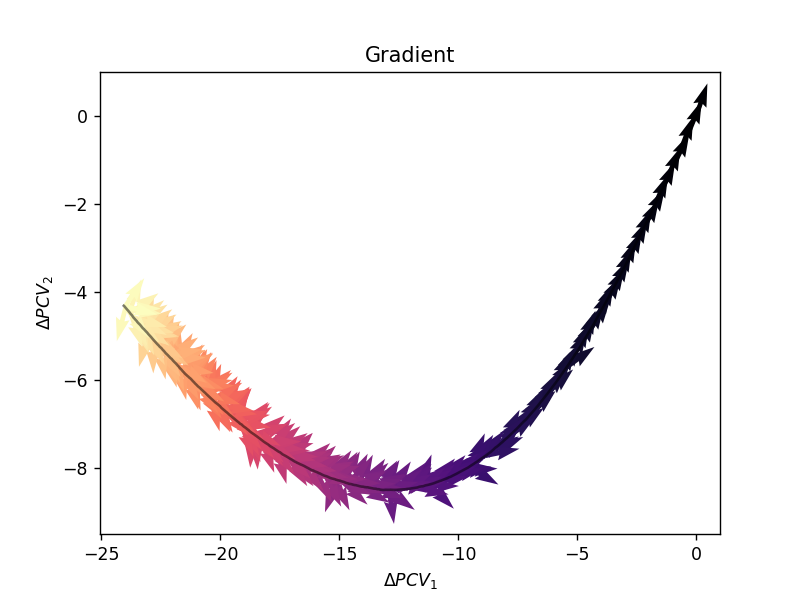

<IPython.core.display.Javascript object>


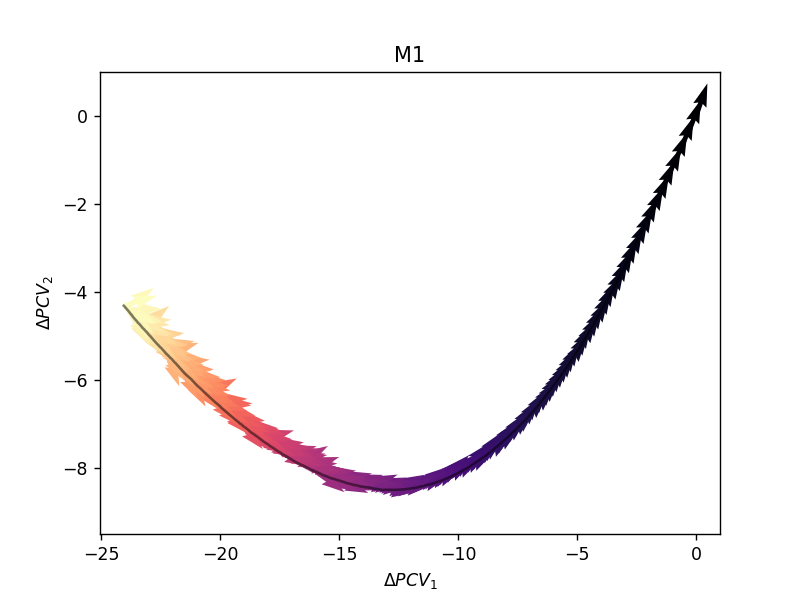

In [18]:
#can adjust pad to zoom in or out
pad = 1
resolution = 200

plt.figure()
plt.plot(pca_vec1_path, pca_vec2_path, c='k', alpha=0.5)

plt.xlim((min(pca_vec1_path)-pad, max(pca_vec1_path)+pad))
plt.ylim((min(pca_vec2_path)-pad, max(pca_vec2_path)+pad))
plt.title("Gradient")
plt.xlabel('$\Delta PCV_{1}$')
plt.ylabel('$\Delta PCV_{2}$')
for t in range(0, num_param_states-1, resolution):
    plt.quiver(pca_vec1_path[t], pca_vec2_path[t], grads_embed[t,0], grads_embed[t,1], color=cm.magma(t/(num_param_states-1)), angles='xy')

plt.figure()
plt.xlim((min(pca_vec1_path)-pad, max(pca_vec1_path)+pad))
plt.ylim((min(pca_vec2_path)-pad, max(pca_vec2_path)+pad))
plt.title("M1")
plt.xlabel('$\Delta PCV_{1}$')
plt.ylabel('$\Delta PCV_{2}$')
#plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap))
plt.plot(pca_vec1_path, pca_vec2_path, c='k', alpha=0.5)
for t in range(0, num_param_states-1, resolution):
    plt.quiver(pca_vec1_path[t], pca_vec2_path[t], m1s_embed[t,0], m1s_embed[t,1], color=cm.magma(t/(num_param_states-1)), angles='xy')


In [19]:
#calculating loss landscape
from mpl_toolkits.mplot3d import Axes3D

def loss_at(param_state):
    state = vector_to_state_dict(param_state, model)

    model.load_state_dict(state)

    this_loss, _ = test(train_data, model, loss_fn)
    return this_loss

def calc_loss_grid(lb1, ub1, lb2, ub2, origin=origin, v1_bins=20, v2_bins=20, filename=r'loss_grid'):
    #data in scatter form (m, b, Loss)
    #loss_grid = np.zeros((100, 100))
    info = np.array([lb1, ub1, lb2, ub2, v1_bins, v2_bins])

    range1 = np.linspace(lb1, ub1, v1_bins)
    range2 = np.linspace(lb2, ub2, v2_bins)

    pnts1 = np.zeros((range1.size*range2.size))
    pnts2 = np.zeros((range1.size*range2.size))
    loss_pnts = np.zeros((range1.size*range2.size))

    idx = 0
    for v1 in range1:
        for v2 in range2:
            if idx != 0 and idx % 10==0:
                print(idx, '/', len(loss_pnts))
            #print(idx, "/", len(b_pnts))
            pnts1[idx] = v1
            pnts2[idx] = v2
            #print(origin.shape, pca_vec1.shape, pca_vec2.shape)
            loss_pnts[idx] = loss_at(origin + v1*pca_vec1 + v2*pca_vec2)
            idx += 1

#     with open(filename + '.npz', 'wb') as file:
#         np.savez(file, info=info, v1_pnts=pnts1, v2_pnts=pnts2, loss_pnts=loss_pnts)
        
    return pnts1, pnts2, loss_pnts


minimum = min(list(pca_vec1_path) + list(pca_vec2_path))
maximum = max(list(pca_vec1_path) + list(pca_vec2_path))
pad = 1*(maximum-minimum)
lb1 = np.mean(pca_vec1_path) - pad
ub1 = np.mean(pca_vec1_path) + pad
lb2 = np.mean(pca_vec2_path) - pad
ub2 = np.mean(pca_vec2_path) + pad

v1_bins = 15
v2_bins = 15

v1_pnts, v2_pnts, loss_pnts = calc_loss_grid(lb1, ub1, lb2, ub2, v1_bins=v1_bins, v2_bins=v2_bins)

10 / 225
20 / 225
30 / 225
40 / 225
50 / 225
60 / 225
70 / 225
80 / 225
90 / 225
100 / 225
110 / 225
120 / 225
130 / 225
140 / 225
150 / 225
160 / 225
170 / 225
180 / 225
190 / 225
200 / 225
210 / 225
220 / 225


<IPython.core.display.Javascript object>


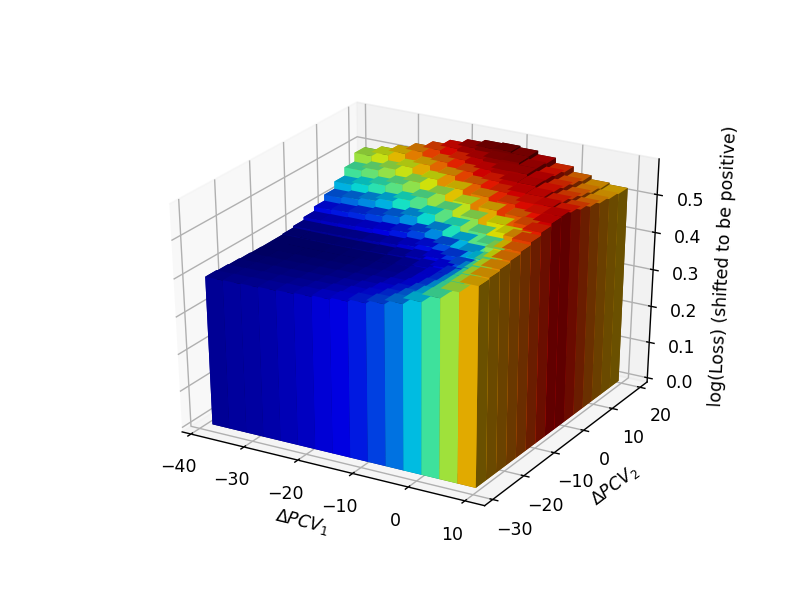

In [20]:
def bar_plot_3d(v1_pnts, v2_pnts, loss_pnts, tuple):

    fig = plt.figure()          #create a canvas, tell matplotlib it's 3d
    ax = fig.add_subplot(111, projection='3d')

    #make histogram stuff - set bins - I choose 20x20 because I have a lot of data
    hist, xedges, yedges = np.histogram2d(v2_pnts, v1_pnts, bins=tuple)
    xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

    #print(xpos)
    xpos = xpos.flatten()/2.
    ypos = ypos.flatten()/2.
    #print(xpos)
    zpos = np.zeros_like(xpos)
    dx = xedges [1] - xedges [0]
    dy = yedges [1] - yedges [0]
    dz = np.log10(loss_pnts) + np.abs(min(np.log10(loss_pnts)))*np.ones_like(loss_pnts)
    #dz = loss_pnts

    #dz[np.argmin(dz)] = 10


    cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
    max_height = np.max(dz)   # get range of colorbars so we can normalize
    min_height = np.min(dz)
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((k-min_height)/(max_height-min_height)) for k in dz]

    ax.bar3d(ypos, xpos, zpos, dx, dy, dz, color=rgba, zsort='average')
    #plt.title("Loss LEGO plot")
    plt.xlabel("$\Delta PCV_{1}$")
    plt.ylabel("$\Delta PCV_{2}$")
    #ax.set_zlabel('Loss')
    ax.set_zlabel('log(Loss) (shifted to be positive)')
    #ax.zaxis.set_scale('log')
    #plt.show()
    return

# with open('loss_grid.npz', 'rb') as f:
#     npzfile = np.load(f)
#     info = npzfile['info']
#     v1_pnts = npzfile['v1_pnts']
#     v2_pnts = npzfile['v2_pnts']
#     loss_pnts = npzfile['loss_pnts']
# lb1 = info[0]
# ub1 = info[1]
# lb2 = info[2]
# ub2 = info[3]
# v1_bins = int(info[4])
# v2_bins = int(info[5])

bar_plot_3d(v1_pnts, v2_pnts, loss_pnts, (int(v1_bins),int(v2_bins)))

<IPython.core.display.Javascript object>


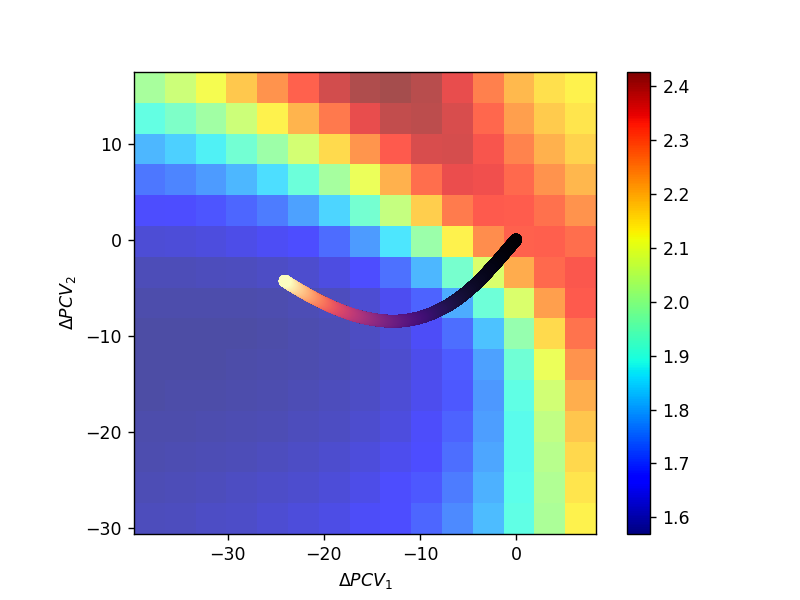

(-30.643714253421262, 17.452468585511678)

In [21]:
#log scaling if wanted
#loss_pnts = np.log10(loss_pnts) + np.abs(min(np.log10(loss_pnts)))*np.ones_like(loss_pnts)

low = min(loss_pnts)
high = max(loss_pnts)
#rescaling elements of loss_pnts
loss_pnts_scaled = (loss_pnts - low*np.ones_like(loss_pnts))/(high-low)

#plt.figure()
cmap1 = cm.plasma
norm1 = colors.Normalize(vmin=min(loss_pnts), vmax=max(loss_pnts))
im_loss = loss_pnts.reshape(v1_bins,v2_bins)

plt.figure()
plt.colorbar(cm.ScalarMappable(norm=norm1, cmap=cm.jet))
plt.imshow(np.flip(im_loss.T, axis=0), extent=[lb1,ub1,lb2,ub2], cmap=cm.jet, alpha=0.7)
plt.scatter(pca_vec1_path, pca_vec2_path, c=[cmap(i/len(pca_vec1_path)) for i in range(len(pca_vec1_path))], alpha=1, zorder=1)
#plt.scatter([250], [250], c=[(0,1,0)])
plt.xlabel('$\Delta PCV_{1}$')
plt.ylabel('$\Delta PCV_{2}$')
plt.xlim(lb1, ub1)
plt.ylim(lb2, ub2)
